# Import Library

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

# Read df

In [3]:
df = pd.read_csv('AER_credit_card_data.csv')

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')


# df.card = pd.to_numeric(df.card, errors='coerce')
# df.card = df.card.fillna(0)

df.card = (df.card == 'yes').astype(int)

In [4]:
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,1,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,1,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,1,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,1,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,1,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


In [5]:
df.card.value_counts()

1    1023
0     296
Name: card, dtype: int64

# Create train test split

In [6]:
df_full_train, df_test = train_test_split(df,test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train,test_size=0.25, random_state=1)

In [7]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.card.values
y_val = df_val.card.values
y_test = df_test.card.values

del df_train['card']
del df_val['card']
del df_test['card']

# Question 1

In [8]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [9]:
numerical = ["reports", "dependents", "active", "share"]

for c in numerical:
    auc = roc_auc_score(y_train, df_train[c])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[c])
    print('%9s, %.3f' % (c, auc))

  reports, 0.717
dependents, 0.533
   active, 0.604
    share, 0.989


# Question 2

In [10]:
columns = [
                'reports', 
                'age', 
                'income',
                'share', 
                'expenditure', 
                'dependents', 
                'months', 
                'majorcards', 
                'active',
                'owner',
                'selfemp'
            ]

In [11]:
dv = DictVectorizer(sparse=False)

train_dicts = df_train[columns].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

val_dicts = df_val[columns].to_dict(orient='records')
X_val = dv.transform(val_dicts)

y_pred = model.predict_proba(X_val)[:, 1]

In [12]:
roc_auc_score(y_val, y_pred)

0.995171242063847

# Question 3

In [13]:
def confusion_matrix_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)
    
    return df_scores

In [14]:
df_scores = confusion_matrix_dataframe(y_val, y_pred)

In [15]:
df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

In [16]:
df_scores.loc[df_scores['threshold']==0.03]

,threshold,tp,fp,fn,tn,p,r
3,0.03,211,24,0,29,0.897872,1.0


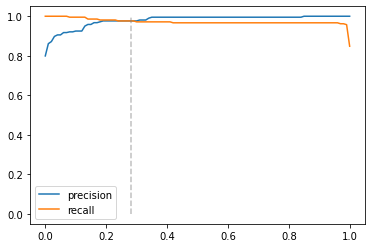

In [17]:
plt.plot(df_scores.threshold, df_scores.p, label='precision')
plt.plot(df_scores.threshold, df_scores.r, label='recall')

plt.vlines(0.28, 0, 1, color='grey', linestyle='--', alpha=0.5)

plt.legend()
plt.show()

# Question 4

In [18]:
df_scores['f1'] = 2 * df_scores.p * df_scores.r / (df_scores.p + df_scores.r)

In [19]:
df_scores

,threshold,tp,fp,fn,tn,p,r,f1
0,0.00,211,53,0,0,0.799242,1.000000,0.888421
1,0.01,211,34,0,19,0.861224,1.000000,0.925439
2,0.02,211,31,0,22,0.871901,1.000000,0.931567
3,0.03,211,24,0,29,0.897872,1.000000,0.946188
4,0.04,211,22,0,31,0.905579,1.000000,0.950450
...,...,...,...,...,...,...,...,...
96,0.96,204,0,7,53,1.000000,0.966825,0.983133
97,0.97,203,0,8,53,1.000000,0.962085,0.980676
98,0.98,203,0,8,53,1.000000,0.962085,0.980676
99,0.99,202,0,9,53,1.000000,0.957346,0.978208


In [20]:
df_scores.threshold.loc[df_scores['f1'] == df_scores['f1'].max()]

35    0.35
36    0.36
37    0.37
38    0.38
39    0.39
40    0.40
41    0.41
Name: threshold, dtype: float64

# Question 5

In [21]:

from sklearn.model_selection import KFold

In [24]:
def train(df_train,y_train, C):
    dicts = df_train[columns].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train,y_train)

    return dv, model

def predict(df,dv,model):
    dicts = df[columns].to_dict(orient='records')
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:,1]
    return y_pred


In [25]:
scores = []

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.card.values
    y_val = df_val.card.values

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.996 +- 0.003


# Question 6

In [27]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for C in [0.01, 0.1, 1, 10]:
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.card.values
        y_val = df_val.card.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%4s, %.5f +- %.5f' % (C, np.mean(scores), np.std(scores)))

C=0.01, 0.99188 +- 0.00560
C= 0.1, 0.99506 +- 0.00395
C=   1, 0.99645 +- 0.00274
C=  10, 0.99639 +- 0.00282
